In [29]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

def visualize_data_fields(pkl_file, sensor_fields=None, mocap_fields=None, labels=None, start_idx=None, end_idx=None, start_time=None, end_time=None, transforms=None):
    """
    Visualize specific data fields from the robot control data format.
    
    Args:
        pkl_file: Path to the pickle file containing data
        sensor_fields: List of indices to plot from sensor_array
                      sensor_array: [height, pitch_body, -roll_body, yaw_body, 
                                   pitch_rate, -roll_rate, yaw_rate, 
                                   y_acceleration, -x_acceleration, z_acceleration, 
                                   motor_1, motor_2, servo_angle_deg]
        mocap_fields: List of indices to plot from mocap_array
                      mocap_array: [pos_x, pos_y, pos_z, rot_roll, rot_pitch, rot_yaw]
        labels: List of labels for the plots (optional, will auto-generate if not provided)
        start_idx: Start index for data slicing (None means from beginning)
        end_idx: End index for data slicing (None means to the end)
        start_time: Start timestamp for data slicing (None means from beginning, takes precedence over start_idx)
        end_time: End timestamp for data slicing (None means to the end, takes precedence over end_idx)
        transforms: Function or list of functions to apply to each field (e.g., np.sin, np.cos, lambda x: x*2)
                   If a single function is provided, it applies to all fields. If a list, must match the number of fields.
    
    Example:
        visualize_data_fields("sensor_data_4.pkl", 
                             sensor_fields=[3],  # yaw
                             labels=["sin(Yaw)"],
                             transforms=[np.sin])
    """
    # Load data
    data = pkl.load(open(pkl_file, "rb"))
    
    # Extract timestamps and arrays
    timestamps = []
    sensor_arrays = []
    mocap_arrays = []
    
    for timestamp, sensor_array, mocap_array in data:
        timestamps.append(timestamp)
        sensor_arrays.append(sensor_array)
        mocap_arrays.append(mocap_array)
    
    timestamps = np.array(timestamps)
    
    # Convert timestamp-based selection to index-based if timestamps are provided
    if start_time is not None or end_time is not None:
        if start_time is not None:
            # Find the first index where timestamp >= start_time
            start_idx = np.searchsorted(timestamps, start_time, side='left')
        if end_time is not None:
            # Find the first index where timestamp > end_time
            end_idx = np.searchsorted(timestamps, end_time, side='right')
    
    # Slice data if indices are provided
    if start_idx is not None or end_idx is not None:
        start_idx = start_idx if start_idx is not None else 0
        end_idx = end_idx if end_idx is not None else len(timestamps)
        timestamps = timestamps[start_idx:end_idx]
        sensor_arrays = sensor_arrays[start_idx:end_idx]
        mocap_arrays = mocap_arrays[start_idx:end_idx]
    
    # Handle transforms - convert to list format if needed
    if transforms is not None:
        if callable(transforms):
            # Single function provided - apply to all fields
            transforms_list = [transforms] * ((len(sensor_fields) if sensor_fields else 0) + (len(mocap_fields) if mocap_fields else 0))
        else:
            # List of functions provided
            transforms_list = transforms
    else:
        transforms_list = None
    
    # Plot sensor fields
    if sensor_fields is not None:
        sensor_field_names = [
            "height", "pitch_body", "-roll_body", "yaw_body",
            "pitch_rate", "-roll_rate", "yaw_rate",
            "y_acceleration", "-x_acceleration", "z_acceleration",
            "motor_1", "motor_2", "servo_angle_deg"
        ]
        
        for idx, field_idx in enumerate(sensor_fields):
            values = np.array([arr[field_idx] for arr in sensor_arrays])
            # Apply transform if provided
            if transforms_list is not None and idx < len(transforms_list) and transforms_list[idx] is not None:
                values = transforms_list[idx](values)
            label = labels[idx] if labels and idx < len(labels) else sensor_field_names[field_idx]
            plt.plot(timestamps, values, label=label)
    
    # Plot mocap fields
    if mocap_fields is not None:
        mocap_field_names = [
            "pos_x", "pos_y", "pos_z", 
            "rot_roll(abt_global_y)", "rot_pitch(abt_global_x)", "rot_yaw(abt_global_z)"
        ]
        
        label_offset = len(sensor_fields) if sensor_fields else 0
        for idx, field_idx in enumerate(mocap_fields):
            values = np.array([arr[field_idx] for arr in mocap_arrays])
            # Apply transform if provided
            transform_idx = label_offset + idx
            if transforms_list is not None and transform_idx < len(transforms_list) and transforms_list[transform_idx] is not None:
                values = transforms_list[transform_idx](values)
            label = labels[label_offset + idx] if labels and (label_offset + idx) < len(labels) else mocap_field_names[field_idx]
            plt.plot(timestamps, values, label=label)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_2d_trajectory(pkl_file, x_field, y_field, x_label="X", y_label="Y", title="2D Trajectory", start_idx=None, end_idx=None, start_time=None, end_time=None):
    """
    Plot a 2D trajectory from mocap data (X vs Y).
    
    Args:
        pkl_file: Path to the pickle file containing data
        x_field: Index of the X field in mocap_array (0 = pos_x)
        y_field: Index of the Y field in mocap_array (1 = pos_y)
        x_label: Label for X axis
        y_label: Label for Y axis
        title: Title of the plot
        start_idx: Start index for data slicing (None means from beginning)
        end_idx: End index for data slicing (None means to the end)
        start_time: Start timestamp for data slicing (None means from beginning, takes precedence over start_idx)
        end_time: End timestamp for data slicing (None means to the end, takes precedence over end_idx)
    
    Example:
        plot_2d_trajectory("sensor_data_4.pkl", x_field=0, y_field=1, 
                          start_time=10.5, end_time=50.2)
    """
    # Load data
    data = pkl.load(open(pkl_file, "rb"))
    
    # Extract timestamps and arrays
    timestamps = []
    mocap_arrays = []
    for timestamp, sensor_array, mocap_array in data:
        timestamps.append(timestamp)
        mocap_arrays.append(mocap_array)
    
    timestamps = np.array(timestamps)
    
    # Convert timestamp-based selection to index-based if timestamps are provided
    if start_time is not None or end_time is not None:
        if start_time is not None:
            # Find the first index where timestamp >= start_time
            start_idx = np.searchsorted(timestamps, start_time, side='left')
        if end_time is not None:
            # Find the first index where timestamp > end_time
            end_idx = np.searchsorted(timestamps, end_time, side='right')
    
    # Slice data if indices are provided
    if start_idx is not None or end_idx is not None:
        start_idx = start_idx if start_idx is not None else 0
        end_idx = end_idx if end_idx is not None else len(mocap_arrays)
        mocap_arrays = mocap_arrays[start_idx:end_idx]
    
    # Extract X and Y values
    x_values = np.array([arr[x_field] for arr in mocap_arrays])
    y_values = np.array([arr[y_field] for arr in mocap_arrays])
    
    # Plot trajectory
    plt.plot(x_values, y_values, marker='o', markersize=2, linewidth=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')  # Equal aspect ratio for better trajectory visualization
    plt.show()

# Example usage
# visualize_data_fields("sensor_data_4.pkl", 
#                      sensor_fields=[7, 8],  # y_acceleration, -x_acceleration
#                      labels=["Y Acceleration", "X Acceleration"])


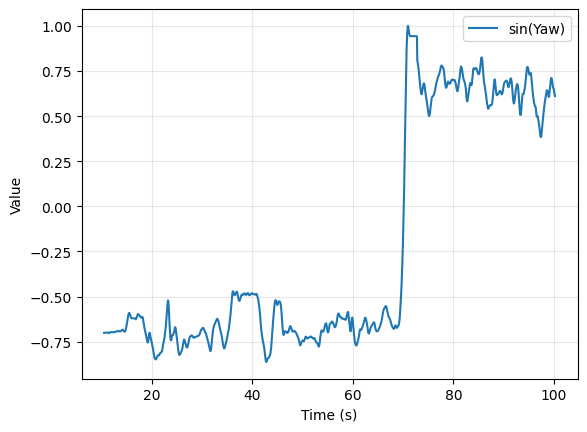

In [30]:
# Example 1: Plot x and y acceleration from sensors
# visualize_data_fields("sensor_data_4.pkl", 
#                      sensor_fields=[8, 7],  # -x_acceleration, y_acceleration (note: index 8 is -x, 7 is y)
#                      labels=["X Acceleration (negated)", "Y Acceleration"])

# Example 2: Plot sin(yaw) using timestamp-based selection (in seconds)
visualize_data_fields("sensor_data_4.pkl",
                     sensor_fields=[3],  # yaw_body
                     labels=["sin(Yaw)"],
                     start_time=10.5,    # Start from timestamp 10.5 seconds
                     end_time=100.2,     # End at timestamp 100.2 seconds
                     transforms=[np.sin])  # Apply sin transformation to yaw

# Alternative: Use index-based selection
# visualize_data_fields("sensor_data_4.pkl",
#                      sensor_fields=[3],
#                      labels=["Yaw"],
#                      start_idx=50,
#                      end_idx=500)

# Example 3: Plot mocap position
# visualize_data_fields("sensor_data_4.pkl",
#                      mocap_fields=[0, 1, 2],  # pos_x, pos_y, pos_z
#                      labels=["Pos X", "Pos Y", "Pos Z"])

# Example 4: Plot both sensor and mocap data
# visualize_data_fields("sensor_data_4.pkl",
#                      sensor_fields=[7, 8],  # y_acceleration, -x_acceleration
#                      mocap_fields=[0, 1],   # pos_x, pos_y
#                      labels=["Y Accel", "X Accel", "Pos X", "Pos Y"])


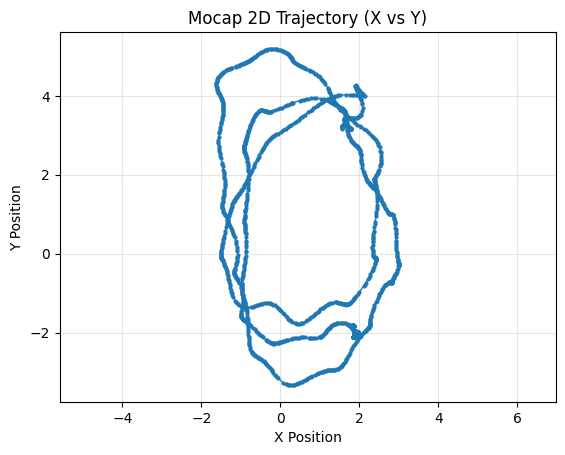

In [39]:
# Plot mocap X and Y position as 2D trajectory (X vs Y)
# You can use timestamp-based or index-based selection
plot_2d_trajectory("in_circle_data_6.pkl",
                   x_field=0,  # pos_x
                   y_field=1,  # pos_y
                   x_label="X Position",
                   y_label="Y Position",
                   title="Mocap 2D Trajectory (X vs Y)",
                   start_time=None,  # Set to None or a timestamp (e.g., 10.5) to start from a specific time
                   end_time=None)    # Set to None or a timestamp (e.g., 50.2) to end at a specific time

# Example: Plot only data from timestamp 10.5 to 50.2 seconds
# plot_2d_trajectory("sensor_data_4.pkl",
#                    x_field=0, y_field=1,
#                    x_label="X Position", y_label="Y Position",
#                    title="Mocap 2D Trajectory (X vs Y) - Selected Time Range",
#                    start_time=10.5, end_time=50.2)

# Alternative: Use index-based selection
# plot_2d_trajectory("sensor_data_4.pkl",
#                    x_field=0, y_field=1,
#                    x_label="X Position", y_label="Y Position",
#                    title="Mocap 2D Trajectory (X vs Y) - Selected Range",
#                    start_idx=100, end_idx=500)

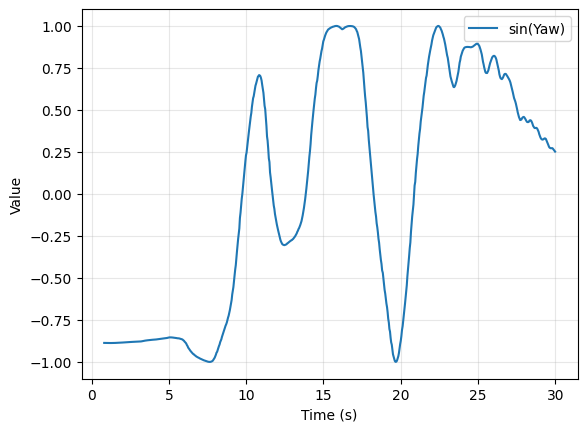

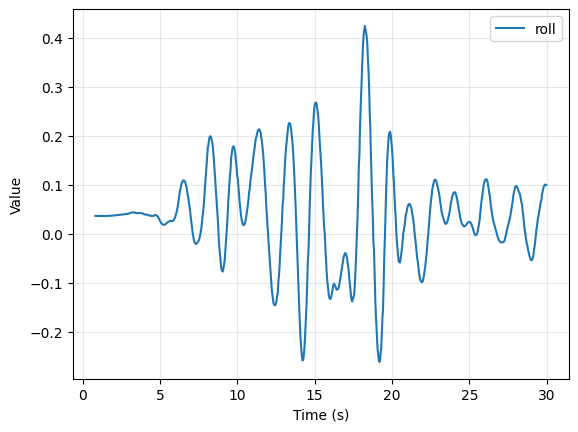

In [38]:
# Plot sin(yaw)
visualize_data_fields("in_circle_data_4.pkl",
                     sensor_fields=[3],  # yaw_body
                     labels=["sin(Yaw)"],
                     start_time=0,
                     end_time=30,
                     transforms=[np.sin])  # Apply sin to yaw

visualize_data_fields("in_circle_data_4.pkl",
                     sensor_fields=[2],  # roll_body
                     labels=["roll"],
                     start_time=0,
                     end_time=30,
                     transforms=[np.sin])  # Apply sin to yaw
